# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Create Master SNP Score Matrix

In [12]:
stage2 = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage2_2019-10-25.tsv', sep='\t')
stage2['effect_allele'] = stage2['effect_allele'].apply(lambda x: str(x).upper())
stage2['noneffect_allele'] = stage2['noneffect_allele'].apply(lambda x: str(x).upper())

for cluster in range(1,25):
    cluster = str(cluster)
    print('Cluster '+cluster)
    effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
    effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
    effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

    print("Num effect sequences:", len(effect_onehot))

    merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

    num_folds = 0
    for fold in range(10):
        effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
        effect_scores = get_hyp_scores(effect_file, effect_seqs)
        effect_scores = np.array(effect_scores)
        if merged_effect_scores.shape == effect_scores.shape:
            merged_effect_scores = merged_effect_scores + effect_scores
            num_folds += 1

    merged_effect_scores = merged_effect_scores / num_folds

    #--------------------------------------------------------#

    noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
    noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
    noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

    print("Num noneffect sequences:", len(noneffect_onehot))

    merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

    num_folds = 0
    for fold in range(10):
        noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
        noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
        noneffect_scores = np.array(noneffect_scores)
        if merged_noneffect_scores.shape == noneffect_scores.shape:
            merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
            num_folds += 1

    merged_noneffect_scores = merged_noneffect_scores / num_folds

    #--------------------------------------------------------#

    merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
    merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

    for fold in range(10):
        ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
        delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
        merged_ism_scores = merged_ism_scores + ism_scores
        merged_delta_scores = merged_delta_scores + delta_scores

    merged_ism_scores = merged_ism_scores / (fold + 1)
    merged_delta_scores = merged_delta_scores / (fold + 1)
    
    #--------------------------------------------------------#
    
    snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
    effect_score = []
    noneffect_score = []
    effect_center = []
    noneffect_center = []
    effect_ratio = []
    noneffect_ratio = []
    allele_ratio = []
    allele_diff = []
    effect_rank = []
    noneffect_rank = []
    ism_score = []
    delta_score = []
    for index,row in snps.iterrows():
        effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
        noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
        effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
        noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
        effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
        noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
        allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
        #allele_diff.append(effect_center[-1] - noneffect_center[-1])
        allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
        effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
        noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    snps['effect_score'] = effect_score
    snps['noneffect_score'] = noneffect_score
    snps['effect_center'] = effect_center
    snps['noneffect_center'] = noneffect_center
    snps['effect_ratio'] = effect_ratio
    snps['noneffect_ratio'] = noneffect_ratio
    snps['allele_ratio'] = allele_ratio
    snps['allele_diff'] = allele_diff
    snps['effect_rank'] = effect_rank
    snps['noneffect_rank'] = noneffect_rank
    snps['ism_score'] = merged_ism_scores
    snps['delta_score'] = merged_delta_scores
    
    #--------------------------------------------------------#

    stage2_explain_ratio = []
    stage2_ism_score = []
    stage2_delta_score = []
       
    for index,row in stage2.iterrows():
        found = snps.loc[(snps['rsid'] == row['rsid']) & (snps['effect'] == row['effect_allele'])]
        if not found.empty:
            num_found = found.shape[0]
            if num_found > 1:
                display(found.head())
            else:
                stage2_explain_ratio.append(found.allele_ratio.iloc[0])
                stage2_ism_score.append(found.ism_score.iloc[0])
                stage2_delta_score.append(found.delta_score.iloc[0])
        else:
            stage2_explain_ratio.append('NAN')
            stage2_ism_score.append('NAN')
            stage2_delta_score.append('NAN')
            
    stage2['Cluster'+cluster+'_explain_ratio'] = stage2_explain_ratio
    stage2['Cluster'+cluster+'_ism_score'] = stage2_ism_score
    stage2['Cluster'+cluster+'_delta_score'] = stage2_delta_score

Cluster 1
Num effect sequences: 642
Num noneffect sequences: 642
Cluster 2
Num effect sequences: 510
Num noneffect sequences: 510
Cluster 3
Num effect sequences: 390
Num noneffect sequences: 390
Cluster 4
Num effect sequences: 436
Num noneffect sequences: 436
Cluster 5
Num effect sequences: 188
Num noneffect sequences: 188
Cluster 6
Num effect sequences: 249
Num noneffect sequences: 249
Cluster 7
Num effect sequences: 379
Num noneffect sequences: 379
Cluster 8
Num effect sequences: 202
Num noneffect sequences: 202
Cluster 9
Num effect sequences: 439
Num noneffect sequences: 439
Cluster 10
Num effect sequences: 230
Num noneffect sequences: 230
Cluster 11
Num effect sequences: 408
Num noneffect sequences: 408
Cluster 12
Num effect sequences: 320
Num noneffect sequences: 320
Cluster 13
Num effect sequences: 304
Num noneffect sequences: 304
Cluster 14
Num effect sequences: 435
Num noneffect sequences: 435
Cluster 15
Num effect sequences: 459
Num noneffect sequences: 459
Cluster 16
Num effe

In [13]:
stage2

,chr,pos,r2_with_ld_tag,ld_tag_chr,ld_tag_pos,source_gwas,source,snp_id,locus_num,number_ld_buddies,ld_tag_locus,rsid,chrom_hg19,snp_pos_hg19,file,effect_allele,noneffect_allele,direction,pvalue,has_coloc,Cluster1_explain_ratio,Cluster1_ism_score,Cluster1_delta_score,Cluster2_explain_ratio,Cluster2_ism_score,Cluster2_delta_score,Cluster3_explain_ratio,Cluster3_ism_score,Cluster3_delta_score,Cluster4_explain_ratio,Cluster4_ism_score,Cluster4_delta_score,Cluster5_explain_ratio,Cluster5_ism_score,Cluster5_delta_score,Cluster6_explain_ratio,Cluster6_ism_score,Cluster6_delta_score,Cluster7_explain_ratio,Cluster7_ism_score,Cluster7_delta_score,Cluster8_explain_ratio,Cluster8_ism_score,Cluster8_delta_score,Cluster9_explain_ratio,Cluster9_ism_score,Cluster9_delta_score,Cluster10_explain_ratio,Cluster10_ism_score,Cluster10_delta_score,Cluster11_explain_ratio,Cluster11_ism_score,Cluster11_delta_score,Cluster12_explain_ratio,Cluster12_ism_score,Cluster12_delta_score,Cluster13_explain_ratio,Cluster13_ism_score,Cluster13_delta_score,Cluster14_explain_ratio,Cluster14_ism_score,Cluster14_delta_score,Cluster15_explain_ratio,Cluster15_ism_score,Cluster15_delta_score,Cluster16_explain_ratio,Cluster16_ism_score,Cluster16_delta_score,Cluster17_explain_ratio,Cluster17_ism_score,Cluster17_delta_score,Cluster18_explain_ratio,Cluster18_ism_score,Cluster18_delta_score,Cluster19_explain_ratio,Cluster19_ism_score,Cluster19_delta_score,Cluster20_explain_ratio,Cluster20_ism_score,Cluster20_delta_score,Cluster21_explain_ratio,Cluster21_ism_score,Cluster21_delta_score,Cluster22_explain_ratio,Cluster22_ism_score,Cluster22_delta_score,Cluster23_explain_ratio,Cluster23_ism_score,Cluster23_delta_score,Cluster24_explain_ratio,Cluster24_ism_score,Cluster24_delta_score
0,1,39822151,0.804516,1,39883756,Alzheimers_Kunkle_2019,LD,1_39822151,31,47,1_39883756,rs34640847,1.0,40287823.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,A,G,+,0.000197,True,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN
1,1,39822245,0.804516,1,39883756,Alzheimers_Kunkle_2019,LD,1_39822245,31,47,1_39883756,rs36015266,1.0,40287917.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,T,C,+,0.000188,True,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN
2,1,39822260,0.804516,1,39883756,Alzheimers_Kunkle_2019,LD,1_39822260,31,47,1_39883756,rs61779808,1.0,40287932.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,A,T,+,0.000223,True,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN
3,1,39822792,0.804516,1,39883756,Alzheimers_Kunkle_2019,LD,1_39822792,31,47,1_39883756,rs61779809,1.0,40288464.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,T,C,+,0.000159,True,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN
4,1,39825225,0.819412,1,39883756,Alzheimers_Kunkle_2019,LD,1_39825225,31,47,1_39883756,rs72666941,1.0,40290897.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,A,C,+,0.000158,True,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN

In [16]:
a = stage2.loc[stage2['rsid']=='rs10426401']

In [17]:
a

,chr,pos,r2_with_ld_tag,ld_tag_chr,ld_tag_pos,source_gwas,source,snp_id,locus_num,number_ld_buddies,ld_tag_locus,rsid,chrom_hg19,snp_pos_hg19,file,effect_allele,noneffect_allele,direction,pvalue,has_coloc,Cluster1_explain_ratio,Cluster1_ism_score,Cluster1_delta_score,Cluster2_explain_ratio,Cluster2_ism_score,Cluster2_delta_score,Cluster3_explain_ratio,Cluster3_ism_score,Cluster3_delta_score,Cluster4_explain_ratio,Cluster4_ism_score,Cluster4_delta_score,Cluster5_explain_ratio,Cluster5_ism_score,Cluster5_delta_score,Cluster6_explain_ratio,Cluster6_ism_score,Cluster6_delta_score,Cluster7_explain_ratio,Cluster7_ism_score,Cluster7_delta_score,Cluster8_explain_ratio,Cluster8_ism_score,Cluster8_delta_score,Cluster9_explain_ratio,Cluster9_ism_score,Cluster9_delta_score,Cluster10_explain_ratio,Cluster10_ism_score,Cluster10_delta_score,Cluster11_explain_ratio,Cluster11_ism_score,Cluster11_delta_score,Cluster12_explain_ratio,Cluster12_ism_score,Cluster12_delta_score,Cluster13_explain_ratio,Cluster13_ism_score,Cluster13_delta_score,Cluster14_explain_ratio,Cluster14_ism_score,Cluster14_delta_score,Cluster15_explain_ratio,Cluster15_ism_score,Cluster15_delta_score,Cluster16_explain_ratio,Cluster16_ism_score,Cluster16_delta_score,Cluster17_explain_ratio,Cluster17_ism_score,Cluster17_delta_score,Cluster18_explain_ratio,Cluster18_ism_score,Cluster18_delta_score,Cluster19_explain_ratio,Cluster19_ism_score,Cluster19_delta_score,Cluster20_explain_ratio,Cluster20_ism_score,Cluster20_delta_score,Cluster21_explain_ratio,Cluster21_ism_score,Cluster21_delta_score,Cluster22_explain_ratio,Cluster22_ism_score,Cluster22_delta_score,Cluster23_explain_ratio,Cluster23_ism_score,Cluster23_delta_score,Cluster24_explain_ratio,Cluster24_ism_score,Cluster24_delta_score
7258,19,44644419,1.0,19,44644419,Alzheimers_Jansen_2018,GWAS,19_44644419,71,962,19_44644419,rs10426401,19.0,45147719.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,G,T,-,4.632150e-14,True,2.16703,0.721843,4.15686,2.05157,0.858491,4.92635,1.80428,0.56398,3.22922,1.9402,0.585776,3.37282,NAN,NAN,NAN,2.58993,0.601254,3.44319,2.45172,0.682147,3.91654,2.28689,0.714782,4.10063,1.61861,0.645634,3.69848,1.68095,0.574053,3.27527,2.16851,0.683226,3.90772,1.55971,0.398794,2.27664,NAN,NAN,NAN,1.54792,0.735491,4.21574,1.49297,0.716634,4.10267,1.44449,0.562639,3.21387,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,1.79762,0.642982,3.68652,1.84161,0.587149,3.37161,NAN,NAN,NAN,NAN,NAN,NAN,1.87899,0.617897,3.54458
7259,19,44644419,1.0,19,44644419,Alzheimers_Kunkle_2019,GWAS,19_44644419,71,855,19_44644419,rs10426401,19.0,45147719.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,T,G,+,5.665000e-11,True,0.461441,-0.721843,-4.15686,0.487413,-0.858491,-4.92635,0.55421,-0.56398,-3.22922,0.515385,-0.585776,-3.37282,NAN,NAN,NAN,0.386084,-0.601254,-3.44319,0.407854,-0.682147,-3.91654,0.437254,-0.714782,-4.10063,0.617799,-0.645634,-3.69848,0.594884,-0.574053,-3.27527,0.461122,-0.683226,-3.90772,0.641117,-0.398794,-2.27664,NAN,NAN,NAN,0.646016,-0.735491,-4.21574,0.669793,-0.716634,-4.10267,0.692269,-0.562639,-3.21387,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,0.556272,-0.642982,-3.68652,0.542983,-0.587149,-3.37161,NAN,NAN,NAN,NAN,NAN,NAN,0.532182,-0.617897,-3.54458
7260,19,44644419,1.0,19,44644419,Alzheimers_Lambert_2013,GWAS,19_44644419,71,670,19_44644419,rs10426401,19.0,45147719.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,G,T,-,2.794000e-09,True,2.16703,0.721843,4.15686,2.05157,0.858491,4.92635,1.80428,0.56398,3.22922,1.9402,0.585776,3.37282,NAN,NAN,NAN,2.58993,0.601254,3.44319,2.45172,0.682147,3.91654,2.28689,0.714782,4.10063,1.61861,0.645634,3.69848,1.68095,0.574053,3.27527,2.16851,0.683226,3.90772,1.55971,0.398794,2.27664,NAN,NAN,NAN,1.54792,0.735491,4.21574,1.49297,0.716634,4.10267,1.44449,0.562639,3.21387,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,1.79762,0.642982,3.68652,1.84161,0.587149,3.37161,NAN,NAN,NAN,NAN,NAN,NAN,1.87899,0.617897,3.54458


In [18]:
stage2.to_csv('/mnt/lab_data3/soumyak/adpd/snp_score_matrix.csv', sep='\t', index=False)

# Create Plots

In [55]:
all_effect = []
all_noneffect = []
all_ratios = []
all_diffs = []
all_ism = []
all_delta = []

for cluster in range(1,25):
    cluster = str(cluster)
    print('Cluster '+cluster)
    effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
    effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
    effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

    print("Num effect sequences:", len(effect_onehot))

    merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

    num_folds = 0
    for fold in range(10):
        effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
        effect_scores = get_hyp_scores(effect_file, effect_seqs)
        effect_scores = np.array(effect_scores)
        if merged_effect_scores.shape == effect_scores.shape:
            merged_effect_scores = merged_effect_scores + effect_scores
            num_folds += 1

    merged_effect_scores = merged_effect_scores / num_folds

    #--------------------------------------------------------#

    noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
    noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
    noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

    print("Num noneffect sequences:", len(noneffect_onehot))

    merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

    num_folds = 0
    for fold in range(10):
        noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
        noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
        noneffect_scores = np.array(noneffect_scores)
        if merged_noneffect_scores.shape == noneffect_scores.shape:
            merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
            num_folds += 1

    merged_noneffect_scores = merged_noneffect_scores / num_folds

    #--------------------------------------------------------#

    merged_effect_svm = np.zeros(shape=(len(effect_onehot),))
    merged_noneffect_svm = np.zeros(shape=(len(effect_onehot),))
    merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
    merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

    for fold in range(10):
        effect_svm = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores').readlines()])
        noneffect_svm = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores').readlines()])
        ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
        delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])

        merged_effect_svm = merged_effect_svm + effect_svm
        merged_noneffect_svm = merged_noneffect_svm + noneffect_svm
        merged_ism_scores = merged_ism_scores + ism_scores
        merged_delta_scores = merged_delta_scores + delta_scores

    merged_effect_svm = merged_effect_svm / (fold + 1)
    merged_noneffect_svm = merged_noneffect_svm / (fold + 1)
    merged_ism_scores = merged_ism_scores / (fold + 1)
    merged_delta_scores = merged_delta_scores / (fold + 1)
    
    snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
    effect_score = []
    noneffect_score = []
    effect_center = []
    noneffect_center = []
    effect_ratio = []
    noneffect_ratio = []
    allele_ratio = []
    allele_diff = []
    effect_rank = []
    noneffect_rank = []
    ism_score = []
    delta_score = []
    for index,row in snps.iterrows():
        effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
        noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
        effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
        noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
        effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
        noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
        allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
        #allele_diff.append(effect_center[-1] - noneffect_center[-1])
        allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
        effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
        noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    snps['effect_score'] = effect_score
    snps['noneffect_score'] = noneffect_score
    snps['effect_center'] = effect_center
    snps['noneffect_center'] = noneffect_center
    snps['effect_ratio'] = effect_ratio
    snps['noneffect_ratio'] = noneffect_ratio
    snps['allele_ratio'] = allele_ratio
    snps['allele_diff'] = allele_diff
    snps['effect_rank'] = effect_rank
    snps['noneffect_rank'] = noneffect_rank
    snps['ism_score'] = merged_ism_scores
    snps['delta_score'] = merged_delta_scores
    
    all_effect += merged_effect_svm.tolist()
    all_noneffect += merged_noneffect_svm.tolist()
    all_ratios += allele_ratio
    all_diffs += allele_diff
    all_ism += merged_ism_scores.tolist()
    all_delta += merged_delta_scores.tolist()

Cluster 1
Num effect sequences: 642
Num noneffect sequences: 642
Cluster 2
Num effect sequences: 510
Num noneffect sequences: 510
Cluster 3
Num effect sequences: 390
Num noneffect sequences: 390
Cluster 4
Num effect sequences: 436
Num noneffect sequences: 436
Cluster 5
Num effect sequences: 188
Num noneffect sequences: 188
Cluster 6
Num effect sequences: 249
Num noneffect sequences: 249
Cluster 7
Num effect sequences: 379
Num noneffect sequences: 379
Cluster 8
Num effect sequences: 202
Num noneffect sequences: 202
Cluster 9
Num effect sequences: 439
Num noneffect sequences: 439
Cluster 10
Num effect sequences: 230
Num noneffect sequences: 230
Cluster 11
Num effect sequences: 408
Num noneffect sequences: 408
Cluster 12
Num effect sequences: 320
Num noneffect sequences: 320
Cluster 13
Num effect sequences: 304
Num noneffect sequences: 304
Cluster 14
Num effect sequences: 435
Num noneffect sequences: 435
Cluster 15
Num effect sequences: 459
Num noneffect sequences: 459
Cluster 16
Num effe

In [57]:
import pickle

# pickle.dump(all_effect, open('/mnt/lab_data3/soumyak/adpd/all_effect.p', 'wb'))
# pickle.dump(all_noneffect, open('/mnt/lab_data3/soumyak/adpd/all_noneffect.p', 'wb'))
# pickle.dump(all_ratios, open('/mnt/lab_data3/soumyak/adpd/all_ratios.p', 'wb'))
# pickle.dump(all_diffs, open('/mnt/lab_data3/soumyak/adpd/all_diffs.p', 'wb'))
# pickle.dump(all_ism, open('/mnt/lab_data3/soumyak/adpd/all_ism.p', 'wb'))
# pickle.dump(all_delta, open('/mnt/lab_data3/soumyak/adpd/all_delta.p', 'wb'))

In [2]:
all_effect = pickle.load(open('/mnt/lab_data3/soumyak/adpd/all_effect.p', 'rb'))
all_noneffect = pickle.load(open('/mnt/lab_data3/soumyak/adpd/all_noneffect.p', 'rb'))
all_ratios = pickle.load(open('/mnt/lab_data3/soumyak/adpd/all_ratios.p', 'rb'))
all_diffs = pickle.load(open('/mnt/lab_data3/soumyak/adpd/all_diffs.p', 'rb'))
all_ism = pickle.load(open('/mnt/lab_data3/soumyak/adpd/all_ism.p', 'rb'))
all_delta = pickle.load(open('/mnt/lab_data3/soumyak/adpd/all_delta.p', 'rb'))

In [3]:
score_dict = {'ratio': all_ratios, 'diff': all_diffs, 
              'ism': all_ism, 'delta': all_delta}

In [4]:
score_df = pd.DataFrame.from_dict(score_dict)

In [5]:
score_df.head()

,ratio,diff,ism,delta
0,0.992417,-0.120434,-0.190862,-1.121088
1,2.319751,0.486904,0.763757,4.403273
2,1.040931,0.031890,0.049888,0.266571
3,0.951473,-0.598793,-0.931719,-5.352862
4,0.973436,-0.007824,-0.012797,-0.051008


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8181560438>]],
      dtype=object)

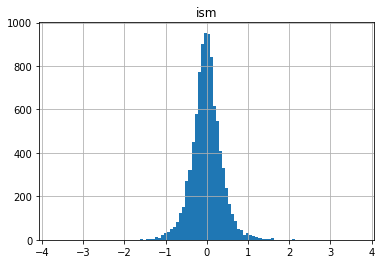

In [7]:
score_df.hist(column='ism', bins=100)

In [61]:
score_df.corr(method='pearson')

,ratio,diff,ism,delta
ratio,1.000000,0.016888,0.017255,0.017239
diff,0.016888,1.000000,0.997895,0.986843
ism,0.017255,0.997895,1.000000,0.984624
delta,0.017239,0.986843,0.984624,1.000000


In [62]:
score_df.corr(method='spearman')

,ratio,diff,ism,delta
ratio,1.000000,0.926266,0.925238,0.924287
diff,0.926266,1.000000,0.997706,0.997503
ism,0.925238,0.997706,1.000000,0.995378
delta,0.924287,0.997503,0.995378,1.000000


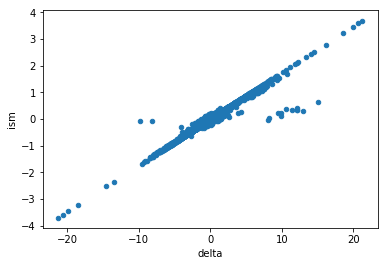

In [78]:
score_df.plot.scatter(x='delta', y='ism')

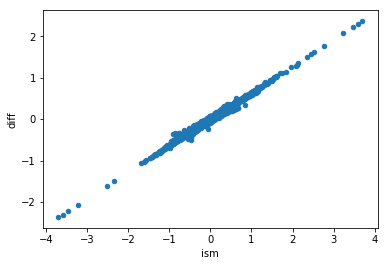

In [79]:
score_df.plot.scatter(x='ism', y='diff')

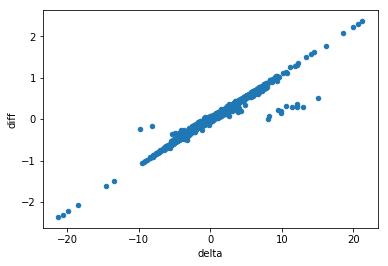

In [80]:
score_df.plot.scatter(x='delta', y='diff')

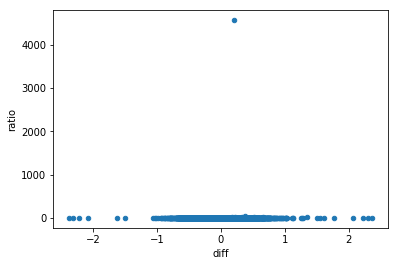

In [81]:
score_df.plot.scatter(x='diff', y='ratio')

In [82]:
score_df2 = score_df.loc[score_df['ratio'] < 5]

In [83]:
score_df2.corr(method='pearson')

,ratio,diff,ism,delta
ratio,1.000000,0.747116,0.746629,0.743329
diff,0.747116,1.000000,0.997845,0.986520
ism,0.746629,0.997845,1.000000,0.984225
delta,0.743329,0.986520,0.984225,1.000000


In [84]:
score_df2.corr(method='spearman')

,ratio,diff,ism,delta
ratio,1.000000,0.925677,0.924641,0.923686
diff,0.925677,1.000000,0.997682,0.997485
ism,0.924641,0.997682,1.000000,0.995337
delta,0.923686,0.997485,0.995337,1.000000


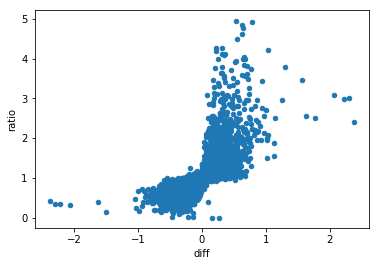

In [85]:
score_df2.plot.scatter(x='diff', y='ratio')

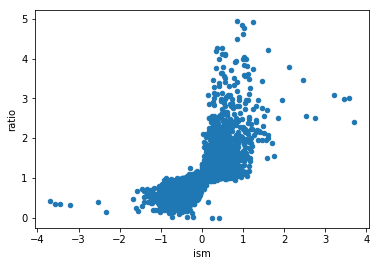

In [86]:
score_df2.plot.scatter(x='ism', y='ratio')

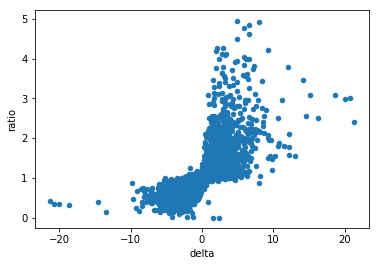

In [87]:
score_df2.plot.scatter(x='delta', y='ratio')

In [88]:
allele_dict = {'effect': all_effect, 'noneffect': all_noneffect}

In [89]:
allele_df = pd.DataFrame.from_dict(allele_dict)

In [90]:
allele_df.head()

,effect,noneffect
0,-1.682626,-1.491764
1,-1.081359,-1.845116
2,-1.760990,-1.810878
3,-2.384680,-1.452961
4,-0.828265,-0.815468


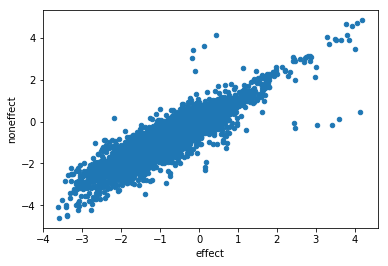

In [91]:
allele_df.plot.scatter(x='effect', y='noneffect')

In [92]:
snp_matrix = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_score_matrix.csv', sep='\t')

In [98]:
microglia = snp_matrix.loc[snp_matrix['Cluster24_ism_score'] != 'NAN']
microglia['Cluster24_ism_score'] = microglia['Cluster24_ism_score'].astype(float)
microglia.loc[(microglia['Cluster24_ism_score'] > 1) | (microglia['Cluster24_ism_score'] < -1)]

,chr,pos,r2_with_ld_tag,ld_tag_chr,ld_tag_pos,source_gwas,source,snp_id,locus_num,number_ld_buddies,ld_tag_locus,rsid,chrom_hg19,snp_pos_hg19,file,effect_allele,noneffect_allele,direction,pvalue,has_coloc,Cluster1_explain_ratio,Cluster1_ism_score,Cluster1_delta_score,Cluster2_explain_ratio,Cluster2_ism_score,Cluster2_delta_score,Cluster3_explain_ratio,Cluster3_ism_score,Cluster3_delta_score,Cluster4_explain_ratio,Cluster4_ism_score,Cluster4_delta_score,Cluster5_explain_ratio,Cluster5_ism_score,Cluster5_delta_score,Cluster6_explain_ratio,Cluster6_ism_score,Cluster6_delta_score,Cluster7_explain_ratio,Cluster7_ism_score,Cluster7_delta_score,Cluster8_explain_ratio,Cluster8_ism_score,Cluster8_delta_score,Cluster9_explain_ratio,Cluster9_ism_score,Cluster9_delta_score,Cluster10_explain_ratio,Cluster10_ism_score,Cluster10_delta_score,Cluster11_explain_ratio,Cluster11_ism_score,Cluster11_delta_score,Cluster12_explain_ratio,Cluster12_ism_score,Cluster12_delta_score,Cluster13_explain_ratio,Cluster13_ism_score,Cluster13_delta_score,Cluster14_explain_ratio,Cluster14_ism_score,Cluster14_delta_score,Cluster15_explain_ratio,Cluster15_ism_score,Cluster15_delta_score,Cluster16_explain_ratio,Cluster16_ism_score,Cluster16_delta_score,Cluster17_explain_ratio,Cluster17_ism_score,Cluster17_delta_score,Cluster18_explain_ratio,Cluster18_ism_score,Cluster18_delta_score,Cluster19_explain_ratio,Cluster19_ism_score,Cluster19_delta_score,Cluster20_explain_ratio,Cluster20_ism_score,Cluster20_delta_score,Cluster21_explain_ratio,Cluster21_ism_score,Cluster21_delta_score,Cluster22_explain_ratio,Cluster22_ism_score,Cluster22_delta_score,Cluster23_explain_ratio,Cluster23_ism_score,Cluster23_delta_score,Cluster24_explain_ratio,Cluster24_ism_score,Cluster24_delta_score
1448,11,60251677,1.000000,11,60251677,Alzheimers_Jansen_2018,GWAS,11_60251677,11,385,11_60251677,rs636317,11.0,60019150.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,C,T,-,2.829881e-13,False,2.4084339129419083,3.694154,21.288200600000003,NAN,NAN,NAN,NAN,NAN,NAN,3.096483306494157,3.2189769999999998,18.5500169,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,2.991311522362123,3.4608510000000003,19.965562,3.0073735846233207,3.585786,20.6858522,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,2.5442678865186887,2.524755,14.534439400000002
1449,11,60251677,1.000000,11,60251677,Alzheimers_Kunkle_2019,GWAS,11_60251677,11,261,11_60251677,rs636317,11.0,60019150.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,T,C,+,5.906000e-15,False,0.41520407826826483,-3.694154,-21.288200600000003,NAN,NAN,NAN,NAN,NAN,NAN,0.32294259295727284,-3.2189769999999998,-18.5500169,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,0.33429752150449366,-3.4608510000000003,-19.965562,0.3325121870488993,-3.585786,-20.6858522,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,0.39303516409249134,-2.524755,-14.534439400000002
1450,11,60251677,1.000000,11,60251677,Alzheimers_Lambert_2013,GWAS,11_60251677,11,184,11_60251677,rs636317,11.0,60019150.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,C,T,-,1.405000e-10,False,2.4084339129419083,3.694154,21.288200600000003,NAN,NAN,NAN,NAN,NAN,NAN,3.096483306494157,3.2189769999999998,18.5500169,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,2.991311522362123,3.4608510000000003,19.965562,3.0073735846233207,3.585786,20.6858522,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,2.5442678865186887,2.524755,14.534439400000002
1666,11,60332878,1.000000,11,60332878,Alzheimers_Jansen_2018,GWAS,11_60332878,11,385,11_60332878,rs2868118,11.0,60100351.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,T,C,+,1.596942e-08,False,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,

In [99]:
excite = snp_matrix.loc[snp_matrix['Cluster1_ism_score'] != 'NAN']
excite['Cluster1_ism_score'] = excite['Cluster1_ism_score'].astype(float)
excite.loc[(excite['Cluster1_ism_score'] > 1) | (excite['Cluster1_ism_score'] < -1)]

,chr,pos,r2_with_ld_tag,ld_tag_chr,ld_tag_pos,source_gwas,source,snp_id,locus_num,number_ld_buddies,ld_tag_locus,rsid,chrom_hg19,snp_pos_hg19,file,effect_allele,noneffect_allele,direction,pvalue,has_coloc,Cluster1_explain_ratio,Cluster1_ism_score,Cluster1_delta_score,Cluster2_explain_ratio,Cluster2_ism_score,Cluster2_delta_score,Cluster3_explain_ratio,Cluster3_ism_score,Cluster3_delta_score,Cluster4_explain_ratio,Cluster4_ism_score,Cluster4_delta_score,Cluster5_explain_ratio,Cluster5_ism_score,Cluster5_delta_score,Cluster6_explain_ratio,Cluster6_ism_score,Cluster6_delta_score,Cluster7_explain_ratio,Cluster7_ism_score,Cluster7_delta_score,Cluster8_explain_ratio,Cluster8_ism_score,Cluster8_delta_score,Cluster9_explain_ratio,Cluster9_ism_score,Cluster9_delta_score,Cluster10_explain_ratio,Cluster10_ism_score,Cluster10_delta_score,Cluster11_explain_ratio,Cluster11_ism_score,Cluster11_delta_score,Cluster12_explain_ratio,Cluster12_ism_score,Cluster12_delta_score,Cluster13_explain_ratio,Cluster13_ism_score,Cluster13_delta_score,Cluster14_explain_ratio,Cluster14_ism_score,Cluster14_delta_score,Cluster15_explain_ratio,Cluster15_ism_score,Cluster15_delta_score,Cluster16_explain_ratio,Cluster16_ism_score,Cluster16_delta_score,Cluster17_explain_ratio,Cluster17_ism_score,Cluster17_delta_score,Cluster18_explain_ratio,Cluster18_ism_score,Cluster18_delta_score,Cluster19_explain_ratio,Cluster19_ism_score,Cluster19_delta_score,Cluster20_explain_ratio,Cluster20_ism_score,Cluster20_delta_score,Cluster21_explain_ratio,Cluster21_ism_score,Cluster21_delta_score,Cluster22_explain_ratio,Cluster22_ism_score,Cluster22_delta_score,Cluster23_explain_ratio,Cluster23_ism_score,Cluster23_delta_score,Cluster24_explain_ratio,Cluster24_ism_score,Cluster24_delta_score
549,10,80493945,0.840117,10,80511585,Alzheimers_Kunkle_2019,LD,10_80493945,5,15,10_80511585,rs7900536,10.0,82253701.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,A,C,+,2.913000e-05,True,1.5242934521356546,1.020218,6.0731023,1.4944617294747295,1.1629305000000003,6.9102288000000005,NAN,NAN,NAN,1.4410810320040348,0.6630998000000001,3.9609991,NAN,NAN,NAN,NAN,NAN,NAN,1.4867245582907398,0.805977,4.7866793,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,1.2468360717346574,0.4893046,2.9149506,NAN,NAN,NAN,1.1382874985924658,0.15031208999999998,0.8944302000000001,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,1.2087881495936077,0.3673113,2.2017724999999997,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN
561,10,102245653,0.987490,10,102255522,Nalls_23andMe,LD,10_102245653,1,9,10_102255522,rs2296887,10.0,104005410.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,T,C,-,6.977320e-03,False,1.6211689829807354,1.070656,6.1680907000000005,3.571243674953902,1.0510749999999998,6.048991,1.3410988536498845,0.5380400999999999,3.1245767,1.5939969524665827,0.9219608000000001,5.2903323,1.7892489364437352,0.5527253,3.2045814999999997,2.075424708883034,0.48323240000000006,2.7780862999999996,1.6892379834094584,0.38713999999999993,2.1989267999999997,1.4239564923861916,0.31582940000000004,1.7814128,1.0128340888455791,0.008578300000000002,0.027074000000000008,1.4287883404554718,0.3401078999999999,1.9430652000000002,1.8015631785691804,0.7730629000000001,4.460841199999999,1.5996927743518639,0.6048099,3.4598673,1.5451582794274485,0.2763631,1.593,1.3613742175438688,0.43772259999999996,2.4773873,1.2070078036152643,0.31164469999999994,1.7380624999999998,1.186296748827786,0.18136649999999999,1.03588,1.2976696412549007,0.2976626,1.6938775,1.7401813987102803,0.34536609999999995,1.9744727000000002,1.2912434889961708,0.270167,1.5535361,1.2070579833489907,0.2527005,1.4207063999999998,1.5757213787370512,0.4754282000000001,2.7136822,1.1683459156238447,0.162716,0.9068524,1.6606200157630122,0.3788911,2.1665663,1.2244975885286236,0.258122,1.4451573
1448,11,60251677,1.000000,11,60251677,Alzheimers_Jansen_2018,GWAS,11_60251677,11,385,11_60251677,rs636317,11.0,60019150.0,/users/mgloud/projects/ad-pd/data/gwas/prepare...,C,T,-,2.